<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2019</span></p>
<p><font size="4">  UE Numerical Methods </font></p>
<p></p>
<p><font size="5">  Notebook 06: Lab - LMS Algorithm - Statement </font></p>
</p></br>
</p>
</CENTER>


--------


# <span style="color:#00B8DE"> LMS equalization for digital data recovery </span>


> - 1  - Generate $n_s=10^4$ symbols of a BPSK modulation.
> - 2  - Convolve symbols with a filter with impulse response given by vector ${\bf h} \propto [1, .8, .3]$ and $\parallel {\bf h}\parallel = 1$. This filter represents the effect of propagation channel on transmitted symbols.
> - 3  - Add noise so as to achieve a fixed SNR at the receiver side. Plot the values of the first 20 symbols and that of the first 20 data samples as well as their sign for $SNR=20dB$. What do we note.
> - 4  - Check that even in the absence of noise the error probability $P_e$ resulting from decisions based on data thresholding would not be zero. Estimate the value of $P_e$ in the absence of equalization.
> - 5  - Implement an LMS filter with impulse response ${\bf w}$ of length $l_w=10$. The stepsize is set to half the maximum suggested stepsize and $SNR=20dB$.
> - 6  - plot the evolution of the distance $\parallel {\bf w}_{MSE}-{\bf w}_{LMS}\parallel $  between the $MSE$ estimate ${\bf w}_{MSE}$ of ${\bf w}$ and successsive LMS estimates $
{\bf w}_{LMS}$.
> - 7  - Study the convergence of the filter, depending on the SNR. 
> - 8  - Train the filter with $n_s=10^4$ symbols. Then generate data for $n_s=10^6$ symbols and $SNR=15dB$. Observe the histogram of data. Whate do you note?
> - 9  - deconvolve the sequence. Estimate the error probability $P_e$. Observe the histograms of equalizer output. remarks?
> - 10 - Analyze the influence of the different parameters (stepsize, SNR, impulse response ${\bf h}$, length of the training sequence, ...) on the behavior of the algorithm. 

## <span style="color:#00B8DE"> Data generation </span>

In [1]:
using Pkg
using LinearAlgebra: norm, tr
using Plots
using DSP
using Statistics
pyplot()

Plots.PyPlotBackend()

In [2]:
 function Conv(X,h)
        Y = zeros(length(X))
        Y[1] = X[1]*h[1]
        Y[2] = Y[1]+X[2]*h[2]
        for i in range(3, stop=length(X))
            Y[i] = sum(X[i-2:i] .*h)
        end
        return Y
    end


Conv (generic function with 1 method)

In [3]:
#1 Generate ns=104 symbols of a BPSK modulation.
ns=Int(1e4)
X = sign.(rand([-1,1], ns))

#2 Convolve symbols with a filter with impulse response given by vector h∝[1,.8,.3] and ∥h∥=1. 
#This filter represents the effect of propagation channel on transmitted symbols.
SNR = 20 
alpha=0.76
h=[1,0.8,0.3]*alpha #(3,)
Y= conv(X, h)
Y = Y[1:10000]

10000-element Array{Float64,1}:
  0.7600000000000008 
  1.3680000000000003 
  1.5959999999999999 
  1.5959999999999996 
  0.0759999999999995 
 -1.1400000000000003 
 -1.5960000000000005 
 -0.076              
 -0.3800000000000004 
  0.3799999999999999 
 -0.3800000000000006 
 -1.14               
 -0.07600000000000054
  ⋮                  
 -0.3799999999999995 
 -1.1400000000000003 
 -0.0760000000000004 
 -0.38000000000000006
  0.37999999999999934
  1.1399999999999995 
  1.5959999999999996 
  0.076              
 -1.1399999999999992 
 -1.5959999999999996 
 -1.5960000000000003 
 -0.0759999999999999 

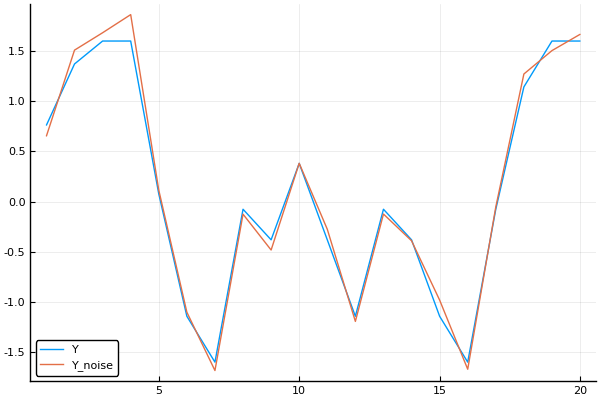

In [4]:
#3 Add noise so as to achieve a fixed SNR at the receiver side. Plot the values of the first 
#20 symbols and that of the first 20 data samples as well as their sign for SNR=20dB. What do we note.
NOISE = randn(ns)
NOISE = NOISE .- mean(NOISE)
signal_power = 1/length(Y)*sum(Y.*Y);
noise_variance = signal_power / ( 10^(SNR/10) )
NOISE=sqrt(noise_variance)/std(NOISE)*NOISE
Y_noise = Y .+ NOISE
# Figures
Plots.plot(Y[1:20], label="Y")
Plots.plot!(Y_noise[1:20], label = "Y_noise") 

Response: The gap between the signal whitout noise and the noised signal is not very significant.

In [5]:
#4  Estimate the value of Pe in the absence of equalization.
print("Pe without equalization = $(sum((abs.(Y .- X)).>1)/ns)")

Pe without equalization = 0.2481

## <span style="color:#00B8DE"> LMS filter </span>

In [6]:
5# MSE solution and accossiated  probability error

# data
#-----
D = X
X = Y_noise
# Initialization of w
#--------------------
p = 10
itr = ns
mu = 0.01
w_mse = [0 for i in range(1,stop=p)]
# MSE solution (min||w'.data-symb||)
#-----------------------------------
iterations=300
for i in range(1, stop = iterations)
    g=  [0 for i in range(1,stop=p)]
    for k in range(p, stop = itr)
        x = X[k-p+1:k]
        g= g .+((sum(x.*w_mse)-D[k]).*x) 
    end
    w_mse = w_mse - mu*2*g/ns
end 

#Reconstruction of the symbol from noised signal on using MSE   
reconstru = zeros(length(X))
for k in range(p, stop = itr)
        x = X[k-p+1:k] 
        reconstru[k]=sum(x.*w_mse)    
end

print("Pe with MSE = $(sum((abs.(reconstru .- D)).>1)/itr)")
# 6-7

Pe with MSE = 0.0

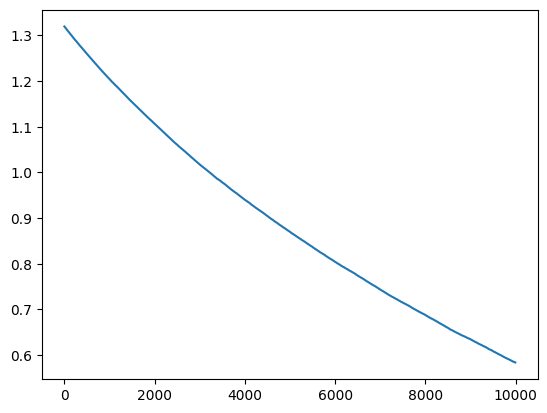

Pe with LMS = 0.0

In [7]:
# LMS solution
#-------------
w_lms = [0 for i in range(1,stop=p)]
his_lms=[zeros(p) for i in range(1 ,stop =itr)]

mu=0
lamdba=0
for k in range(p, stop = itr)    
    x = X[k-p+1:k] 
    lamdba +=sum(x .*x) # Using trace to replace the maximum engine value to ensure the constraint of convergence      
end
lamdba/=(10)
mu=1/lamdba

for k in range(p, stop = itr)
        
    x = X[k-p+1:k]  
    y=sum(x.*w_lms)    
    en= y -D[k]
    w_lms = w_lms - 2*mu*en.*x 
    his_lms[k] = w_lms
end

# 6-7
his_lms = his_lms[p:itr]
trace = zeros(itr-p+1)
for i in range(1, stop=(itr-p+1))
    trace[i] = norm(his_lms[i].- w_mse)
end
PyPlot.plot(trace)

#Reconstruction of the symbol from noised signal on using LMS
reconstru = zeros(length(X))
for k in range(p, stop = itr)
        x = X[k-p+1:k] 
        reconstru[k]=sum(x.*w_lms)    
end

print("Pe with LMS = $(sum((abs.(reconstru .- D)).>1)/itr)")

## <span style="color:#00B8DE"> Deconvolution </span>

In [8]:
# 8
# Equalizer design
function generateSignal(ns, X, SNR) 
    ns = Int(ns)
    alpha=0.76
    h=[1,0.8,0.3]*alpha #(3,)
    Y= conv(X, h)[1:ns]
    NOISE = randn(ns)
    NOISE = NOISE .- mean(NOISE)
    signal_power = 1/length(Y)*sum(Y.*Y);
    noise_variance = signal_power / ( 10^(SNR/10) )
    NOISE=sqrt(noise_variance)/std(NOISE)*NOISE
    Y_noise = Y .+ NOISE
    return Y_noise
end

function LMS(Y_noise, X, itr)
    
   
    p = Int(10)
    D = X
    X = Y_noise
    w_lms = [0 for i in range(1,stop=p)]
    his_lms=[zeros(p) for i in range(1 ,stop =itr)]
    mu=0
    lamdba=0
    for k in range(p, stop = itr)    
        x = X[k-p+1:k] 
        lamdba +=sum(x .*x)    
    end
    lamdba/=(10)
    mu=1/lamdba
    for k in range(p, stop = itr)

        x = X[k-p+1:k] 
        y=sum(x.*w_lms)    
        en= y -D[k]
        w_lms = w_lms - 2*mu*en.*x 
        his_lms[k] = w_lms
    end
    return w_lms, his_lms
end


function MSE(Y_noise, X, ns)
    D = X
    #X = Y[2:length(Y)-1]
    X = Y_noise
    p = 10
    itr = ns
    mu = 0.01
    w_mse = [0 for i in range(1,stop=p)]
    iterations=300
    for i in range(1, stop = iterations)
        g=  [0 for i in range(1,stop=p)]
        for k in range(p, stop = itr)
            x = X[k-p+1:k]
            g= g .+((sum(x.*w_mse)-D[k]).*x) 
        end
        w_mse = w_mse - mu*2*g/ns
    end
    return w_mse
end

MSE (generic function with 1 method)

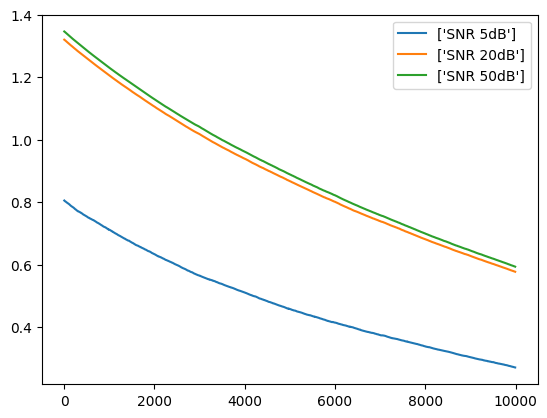

PyObject <matplotlib.legend.Legend object at 0x7f539ae6bcc0>

In [9]:
#7 - Study the convergence of the filter, depending on the SNR.
function dessin(his_lms, w_mse, p, itr)
    his_lms = his_lms[p:itr]
    trace = zeros(itr-p+1)
    for i in range(1, stop=(itr-p+1))
        trace[i] = norm(his_lms[i].- w_mse)
    end
    return trace
end



itr = Int(1e4)
X = sign.(rand([-1,1], itr))
Y_noise_5dB = generateSignal(itr, X, 5)
w_lms_5dB, his_lms_5dB = LMS(Y_noise_5dB, X, itr)
w_mse_5dB = MSE(Y_noise_5dB, X, itr)

Y_noise_20dB = generateSignal(itr, X, 20)
w_lms_20dB, his_lms_20dB = LMS(Y_noise_20dB, X, itr)
w_mse_20dB = MSE(Y_noise_20dB, X, itr)

Y_noise_50dB = generateSignal(itr, X, 50)
w_lms_50dB, his_lms_50dB = LMS(Y_noise_50dB, X, itr)
w_mse_50dB = MSE(Y_noise_50dB, X, itr)

p = Int(10)
trace_5dB = dessin(his_lms_5dB, w_mse_5dB, p, itr)
trace_20dB = dessin(his_lms_20dB, w_mse_20dB, p, itr)
trace_50dB = dessin(his_lms_50dB, w_mse_50dB, p, itr)

x = range(1, stop= length(trace_5dB))
PyPlot.plot(x, trace_5dB, label=["SNR 5dB"])
PyPlot.plot(x, trace_20dB, label=["SNR 20dB"])
PyPlot.plot(x, trace_50dB, label=["SNR 50dB"])
PyPlot.legend()

Response to question 7:When SNR is large, the weight of LMS convege to the weight of MSE better than the case where SNR is small. 

In [10]:
#8 Data generation
itr = Int(1e6)
X_8 = sign.(rand([-1,1], itr))
Y_noise_8 = generateSignal(itr,X_8, 15)
w_lms_8, his_lms_8 = LMS(Y_noise_8, X_8, itr)
reconstru = zeros(length(Y_noise_8))

# 9 Deconvolution of signal 
for k in range(p, stop = itr)
        x = Y_noise_8[k-p+1:k] 
        reconstru[k]=sum(x.*w_lms_8)    
end
reconstru = sign.(reconstru)
#reconstru = reconstru
print("Pe with LMS with SNR 20 = $(sum((abs.(reconstru .- X_8)).>1)/itr)")

Pe with LMS with SNR 20 = 0.007011

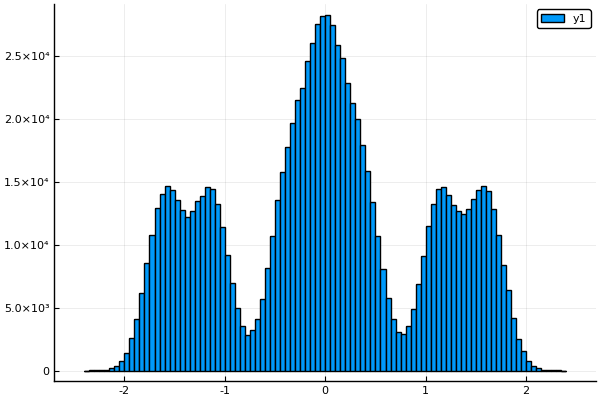

In [11]:
# Dhistogram of equalizer outputs
#8- Train the filter with ns=104 symbols. Then generate data for ns=106 symbols and SNR=15dB. 
#Observe the histogram of data. Whate do you note?
histogram(Y_noise_8)

From the image above, we find that the signal is very noisy. There isn't so much point at -1 or 1.

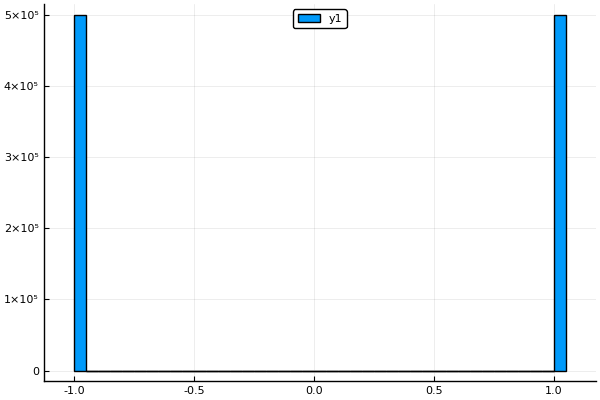

In [12]:
histogram(reconstru)

Reponse: From the image above, we find that we succeed in reconstructing the symbol, with a low Pe(0.006879).